# Chunky Monkey Experiment Notebook

This notebook is a testing ground for the concepts required for chunky monkey; a data science tool for finding an optimal chunking strategy for a given corpus. Ultimately chunky monkey should be integrated with the RAG Experiment Accelerator.

The overall intended process is as follows:

1. Define document clusters that map to topics, creating a "topic vector" by taking the element-wise mean of all document vectors in a topic.
2. Iterate through a document, evaluating all potential chunks (determined by user input parameters) cosine similarity against topic vectors.
3. Use the cTF-IDF defined words to label topics via a request to Azure OpenAI.

The hypothesis is that by selecting the chunking strategy that maximises cosine similarity with analytically derived topics, we can boost relevance scores within a RAG system.

### What we'll cover:

- Import some sample data
- Create a topic model using [BERTopic](https://maartengr.github.io/BERTopic/index.html)
- Capture the topic vectors
- Extract all the topic terms
- Submit the topic terms to OpenAI to get a sensible topic label
- Scan through the document, and for each potential chunk, embed it and calculate the cosine similarity against each topic vetor
- Select the optimal chunks based on the highest cosine similarity, capturing the topic label

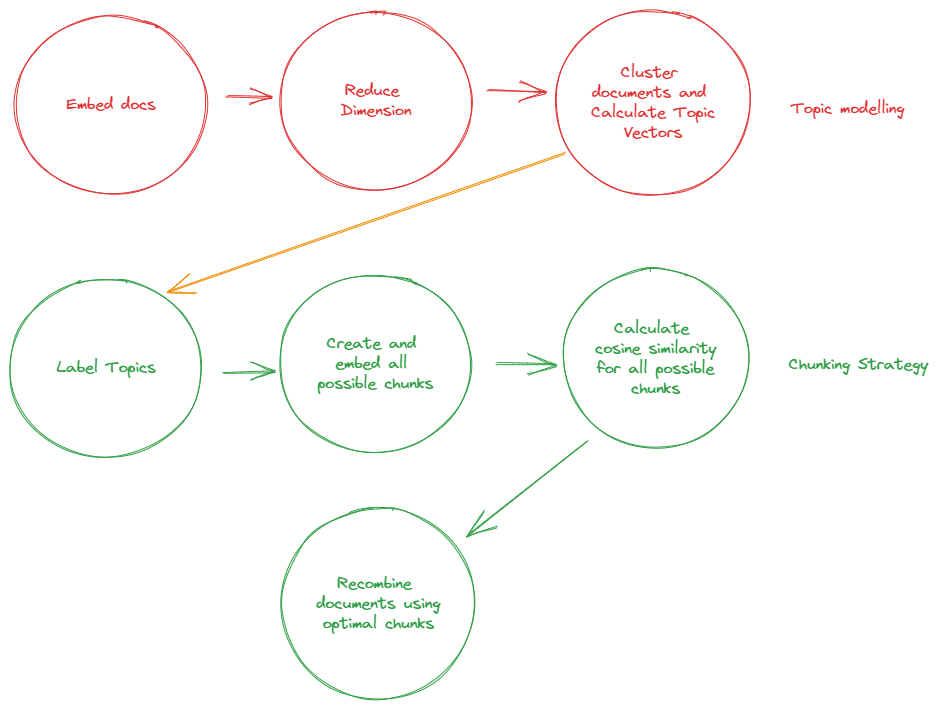

### Future work
The aim is to integrate this work with the [RAG Experiment Accelerator](https://github.com/microsoft/rag-experiment-accelerator) so that this can be used as a target chunking strategy, and measure the overall efficacy of a RAG system.

Let's go!

## Environment Setup
We'll start by taking a look at your environment and configuring it to use the optimal GPU setup. If you don't have a GPU, don't worry, it'll just use the CPU.


In [ ]:
import torch
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

has_gpu = torch.cuda.is_available()
has_mac_gpu = torch.backends.mps.is_built()
device = "mps" if has_mac_gpu else "cuda" if torch.cuda.is_available() else "cpu"

print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mac_gpu else "NOT AVAILABLE")
print(f"Target device is {device}")

## Import data
We'll begin by importing a list of news articles from the scikit learn package. Given a large number of documents can cover a huge number of topics, for testing/learning purposes its recommended to subset the list down to 2500 documents. We've created a helper function to bring in the data.

In [ ]:
from topic.modelling import create_and_fit_topic_model
from data_processing.example import create_example_input_docs
from topic.labels import extract_all_topics, label_topics
import topic.vector_processing as vp

# Restrict to 2500 documents for testing
docs = create_example_input_docs(records=2500, seed=42)

## Create our topic model

What we're aiming to do here is understand the themes (topics) within our corpus.

Topic modelling is beyond the scope of this notebook, but we'll give a brief outline of the approach here. The intention is to scan our corpus and algorithmically determine what the common themes are. There are a number of well established techniques to do this. We've chosen the implement the [BERTopic](https://maartengr.github.io/BERTopic/index.html) package here as it is simple, pretty sophisticated and well documented.

At a high level this works by applying the following steps:
- Embed each document
- Reduce the number of dimensions
- Cluster the documents
- Tokenise the documents
- Apply a word weighting scheme

What's great about the package is that it's designed as plug and play, so that you can use your algorithm of choice at each step.

<div style="text-align: center;">

![alt text](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.svg "BERTopic components")

</div>


In [ ]:
# 1 min v100 full dset
# 1 min 30 s A2000 full dset
kb_topic_model, topics, probs = create_and_fit_topic_model(docs)
torch.cuda.empty_cache()

## Extracting and Labelling the Topics
Now we want to take all of the topics and given them a name. Most topic modelling techniques provide an ID, and a set of words that define the topic. We want to make that ID meaningful to a human. First we extract all of the topic terms, and then we label them by constructing a prompt, and submitting it to GPT3.5, asking it to come up wth a two word label for the topic. We combine the labels and terms into a dictionary that we can then use to caluclate "densities" across potential chunks of our input documents.

Sometimes, particularly with news datasets, a topic list may trigger a content filter. In that case the label is created by concatenating the first two topic terms.

In addition we'll extract the topic vector, which is the represents the mean embedding vector for each topic.

In [ ]:
# This should have a small number of topics, resulting in a small number of calls to OpenAI
# 1-2 mins on full dset ~200 topics
extracted_topics = extract_all_topics(kb_topic_model.get_topics())

topic_embeddings = kb_topic_model.topic_embeddings_.tolist()

labelled_topics = label_topics(extracted_topics, topic_embeddings=topic_embeddings)


## Topic Based Chunking (TBC)

Now we have our topics, lets see how densely they are represented in our documents. We create all possible chunks based on user provided hyper parameters (min number of sentences, max number of sentence, overlap between chunks) for each document, we then embed each chunk, and caclulate the distance from each topic vector. It then selects the optimal chunk by taking the maximum value across topics. This is then labelled as the primary topic.


> **NOTE**: For a large corpus, unless you (or your data scientist) have carefully curated your number of topics, you may end up needing to do a lot of computation. Remember that for each doc, for each potential chunk, for each topic you will be calculating a metric. Where possible code has been vectorised to improve performance.  

Let's run the code and take a look at the results.

In [ ]:
# 9 mins on v100 full dset
# 35 mins on a2000 full dset

# Split and reconstitute the documents, breaking them into sentences and reassemble as parameter driven chunks
potential_chunks = vp.split_and_reconstitute(docs, 2,5,1)

# Create embeddings for the potential chunks
potential_chunks_embedded = vp.create_chunk_embeddings(potential_chunks, "string")

# Calculate similarity between potential chunks and topic vectors
potential_chunks_embedded_metrics = vp.calculate_similarity(potential_chunks_embedded, "embeddings", labelled_topics)

# Find the chunk with the highest cosine similarity and corresponding topic
potential_chunks_embedded_best_metrics = vp.identify_max_topic(potential_chunks_embedded_metrics,labelled_topics)

torch.cuda.empty_cache()

## Selecting the optimal chunks

Now we know the best topic associated with each possible chunk, we can select the best set of chunks for each document. 

In [ ]:
# 6mins on v100 full dataset (CPU only)
# 6mins local (CPU only)
optimally_chunked_corpus = vp.select_max_metric_chunks(potential_chunks_embedded_best_metrics)
optimally_chunked_corpus.head(30)